# Connecting with google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# Import Neccessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import PIL

from keras import models
from keras.utils import pad_sequences
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

# Load Model, Tokenizer, features and Captions

In [3]:
model = models.load_model("/content/drive/MyDrive/Project/Image-Captioning Project/Model Building/model.h5")

with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/tokenizer.pkl", "rb") as f:
  tokenizer = pickle.load(f)

with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/all_captions.pkl", "rb") as f:
  all_captions = pickle.load(f)
with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/captions_dict.pkl", "rb") as f:
  captions_dict = pickle.load(f)

with open("/content/drive/MyDrive/Project/Image-Captioning Project/Preprocessing/features.pkl", "rb") as f:
  img_features = pickle.load(f)

with open("/content/drive/MyDrive/Project/Image-Captioning Project/Model Building/history.pkl", "rb") as f:
  history = pickle.load(f)

In [4]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 35)]                 0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 4096)]               0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 35, 256)              2172160   ['input_14[0][0]']            
                                                                                                  
 dropout_12 (Dropout)        (None, 4096)                 0         ['input_13[0][0]']            
                                                                                            

In [5]:
all_captions[0]

'<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>'

In [6]:
max_len = max(len(token.split()) for token in all_captions)
max_len

35

# Generating captions for the Image

In [7]:
def idx_to_integer(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [8]:
# generating captions for the image
def predict_captions(image, model, tokenizer, max_len):
  # add <startseq> tag for generation of sequence
  in_text = "<startseq>"
  # iterate over the max_length of sequence
  for i in range(max_len):
    # encode input sequence
    seq = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequnece
    seq = pad_sequences([seq], max_len, padding="post")
    # predict the next word
    y_hat = model.predict([image, seq], verbose=0)
    # get index with high probablity
    y_hat = np.argmax(y_hat)
    # convert index to word
    word = idx_to_integer(y_hat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    # stop if we reach at <endseq> tag
    if word == "endseq":
      in_text += ' <endseq>'
      break
    in_text += ' ' + word
  return in_text

# Validate with test data

In [9]:
li_keys = list(img_features.keys())
split = int(len(li_keys) * 0.90)
train = li_keys[:split]
test = li_keys[split:]

In [10]:
len(test)

810

In [11]:
actual, predict = list(), list()
for key in tqdm(test):
  # get actual caption
  captions = captions_dict[key]
  # predict the caption for the image
  y_hat = predict_captions(img_features[key], model, tokenizer, max_len)
  # split into words
  actual_caption = [caption.split() for caption in captions]
  y_hat = y_hat.split()
  # append in the list
  actual.append(actual_caption)
  predict.append(y_hat)

# calculate BLEU score (used when using text)
print("BLEU-1: %f" % corpus_bleu(actual, predict, weights=(1.0, 0, 0, 0)))
print("BLEU-1: %f" % corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [08:39<00:00,  1.56it/s]


BLEU-1: 0.616747
BLEU-1: 0.426457


# Visualizing the Result

In [18]:
def generate_image(image_name):
    image_id = image_name.split(".")[0]
    image = PIL.Image.open(image_name)

    # predict the caption
    y_pred = predict_captions(img_features[image_id], model, tokenizer, max_len)
    print(y_pred)

    # plot image without x-axis and y-axis
    plt.figure(figsize=(4, 6))
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

<startseq> two dogs are playing with each other on the beach <endseq>


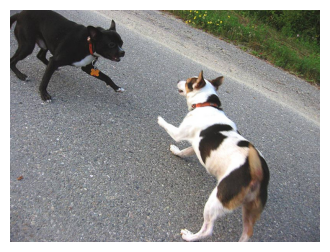

In [30]:
generate_image('1001773457_577c3a7d70.jpg')

<startseq> little boy climbing ropes net <endseq>


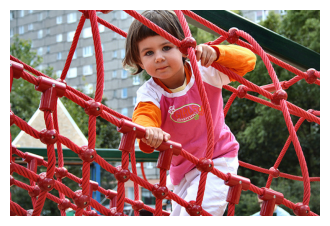

In [22]:
generate_image('1007320043_627395c3d8.jpg')

<startseq> man with gauges and glasses is wearing blitz hat <endseq>


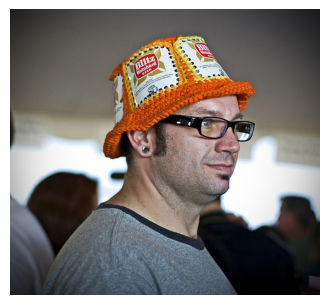

In [24]:
generate_image('1007129816_e794419615.jpg')

<startseq> man lays on the bench while man sits on the ground by him <endseq>


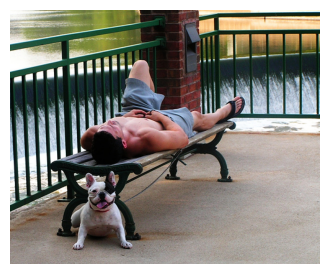

In [26]:
generate_image('1003163366_44323f5815.jpg')

# Visualizing the loss and the accuracy

In [31]:
loss = []
accuracy = []
for i in history:
  loss.append(i.history['loss'])
  accuracy.append(i.history['accuracy'])

loss[:5], accuracy[:5]

([[5.20552921295166],
  [4.001427173614502],
  [3.5798351764678955],
  [3.314302682876587],
  [3.1186861991882324]],
 [[0.15244270861148834],
  [0.2531500458717346],
  [0.2866405248641968],
  [0.30623093247413635],
  [0.3216400146484375]])

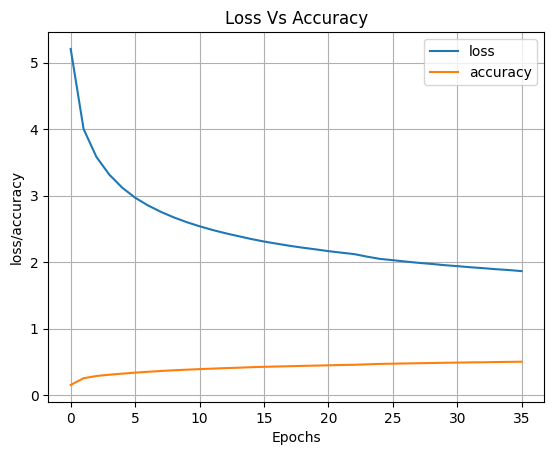

In [32]:
plt.plot([i for i in range(len(loss))], loss, label="loss")
plt.plot([i for i in range(len(loss))], accuracy, label="accuracy")
plt.title("Loss Vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss/accuracy")
plt.grid()
plt.legend()
plt.show()